# Introduction to Data Science 2025

# Bonus exercises

## Exercise 1: EDA of unemployed highly educated people in Finland

In this assignment, you will explore time series data on unemployment of highly educated people in Finland combined with two datasets of your own choosing. The idea of the assignment is to look into how the unemployed highly educated population varies over time and across different areas by using the data wrangling, exploratory data analysis, and visualization tools discussed during the course.

First, please download the Statistics Finland's CSV dataset (available in the course MOOC Materials) that contains data on employment and unemployment numbers grouped by level of education, province, and year.

Read in the data to a data frame, and have a look at the rows and columns it contains. For ease of use, you can set the year column as the index. Perform any other preprocessing you see fit. If you are working in Python, you can do this using the pandas library. 

**Hint**: you can also create new useful columns using the existing ones. 

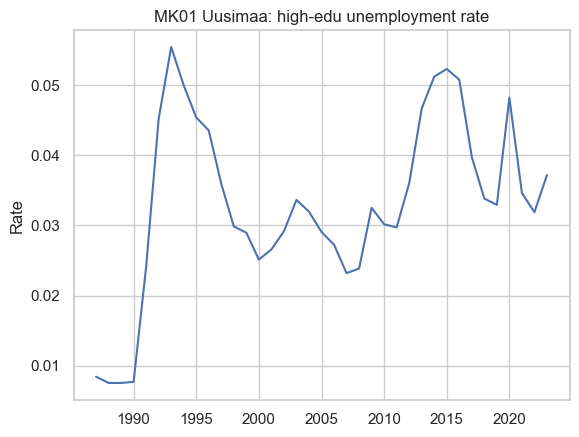

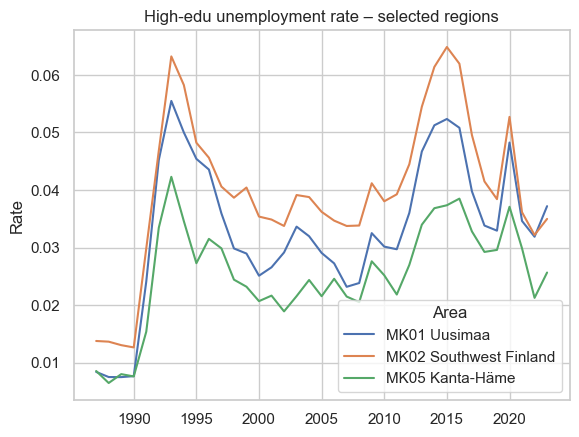

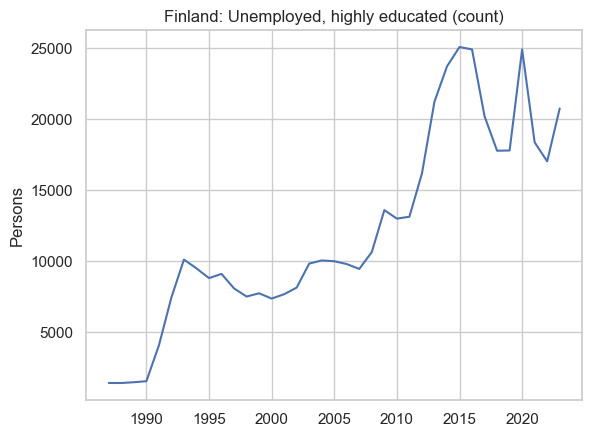

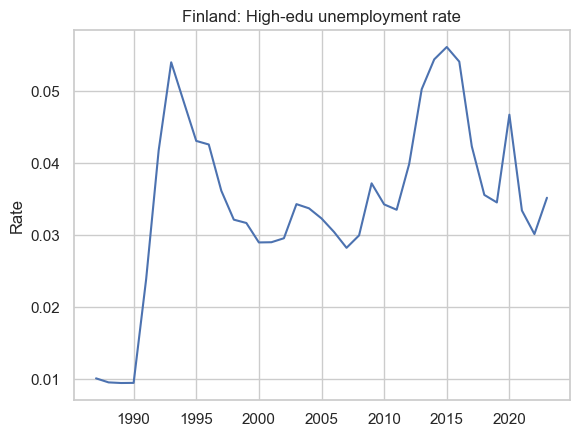

In [ ]:
## Use this cell for your code
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


PATH = "/home/haarhaar/koulu/intro/Introduction-to-DataScience/Extra assignments/JyUmCNsMXCGJ3VX2WInilGfPB24AZH.csv"
df = pd.read_csv(PATH, encoding="latin1").rename(columns={
    "Year":"year","Area":"area","Main type of activity":"main_activity",
    "Level of education":"edu_level","Population 31 Dec":"population"
})
HIGH = "7-8 Master's or equivalent level or doctoral or equivalent level"

parts = {
    "unemployed_high_edu": "main_activity == 'Unemployed' and edu_level == @HIGH",
    "total_high_edu_pop":  "main_activity == 'Total' and edu_level == @HIGH",
    "total_unemployed":    "main_activity == 'Unemployed' and edu_level == 'Total'",
    "total_population":    "main_activity == 'Total' and edu_level == 'Total'",
}
tables = [df.query(q)[["year","area","population"]].rename(columns={"population":k}) for k,q in parts.items()]
eda = tables[0].merge(tables[1], on=["year","area"], how="outer") \
               .merge(tables[2], on=["year","area"], how="outer") \
               .merge(tables[3], on=["year","area"], how="outer")
eda["high_edu_unemployment_rate"] = eda["unemployed_high_edu"] / eda["total_high_edu_pop"]
eda["share_of_unemployed_who_are_high_edu"] = eda["unemployed_high_edu"] / eda["total_unemployed"]
eda["high_edu_share_in_population"] = eda["total_high_edu_pop"] / eda["total_population"]

# --- totals per year ---
finland = (eda.groupby("year", as_index=False)
             .sum(numeric_only=True, min_count=1))
finland["high_edu_unemployment_rate"] = finland["unemployed_high_edu"] / finland["total_high_edu_pop"]

# --- Single region ---
area = "MK01 Uusimaa"
g1 = eda[eda["area"]==area].sort_values("year")
sns.lineplot(data=g1, x="year", y="high_edu_unemployment_rate")
plt.title(f"{area}: high-edu unemployment rate"); plt.xlabel(""); plt.ylabel("Rate"); plt.show()

# --- Compare regions ---
regions = ["MK01 Uusimaa","MK02 Southwest Finland","MK05 Kanta-Häme"]
g2 = eda[eda["area"].isin(regions)].dropna(subset=["high_edu_unemployment_rate"])
sns.lineplot(data=g2, x="year", y="high_edu_unemployment_rate", hue="area")
plt.title("High-edu unemployment rate – selected regions"); plt.xlabel(""); plt.ylabel("Rate"); plt.legend(title="Area"); plt.show()

# --- National trend ---
sns.lineplot(data=finland.sort_values("year"), x="year", y="unemployed_high_edu")
plt.title("Finland: Unemployed, highly educated (count)"); plt.xlabel(""); plt.ylabel("Persons"); plt.show()

sns.lineplot(data=finland.sort_values("year"), x="year", y="high_edu_unemployment_rate")
plt.title("Finland: High-edu unemployment rate"); plt.xlabel(""); plt.ylabel("Rate"); plt.show()




Next, find two time series datasets of your choice to combine with the unemployment data. These can be time series data on factors that you are interested in that might be connected to unemployment, and should cover at least some of the same years as the unemployment data. Please find the datasets from some source other than Statistics Finland (Tilastokeskus).

Read in your datasets, perform any necessary cleaning (such as handling missing values or removing unnecessary columns, et cetera). Preprocess the data so that the features are presented on a yearly level. Then, combine the preprocessed datasets to the unemployment data using the year column to link the datasets.

In [ ]:
## Use this cell for your code
from pathlib import Path

def to_yearly_mean(df, date_col, value_col):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d[value_col] = pd.to_numeric(d[value_col], errors="coerce")
    d = d.dropna(subset=[date_col, value_col])
    d["year"] = d[date_col].dt.year
    return d.groupby("year", as_index=False)[value_col].mean()


# ----- us treasuyury T10Y2Y -----
t10_path = Path("/home/haarhaar/koulu/intro/Introduction-to-DataScience/Extra assignments/T10Y2Y.csv")
t10 = pd.read_csv(t10_path)
date_col = next(c for c in t10.columns if "date" in c.lower())
val_col = "T10Y2Y" if "T10Y2Y" in t10.columns else [c for c in t10.columns if c != date_col][0]
t10_year = to_yearly_mean(t10, date_col, val_col).rename(columns={val_col:"T10Y2Y_avg"})

# ---------- ECB  household loans ----------
ecb_path = Path("/home/haarhaar/koulu/intro/Introduction-to-DataScience/Extra assignments/ECB Data Portal_20251020144654.csv")
ecb = pd.read_csv(ecb_path)
ecb_date = "DATE" if "DATE" in ecb.columns else next(c for c in ecb.columns if "date" in c.lower())
ecb_val_exact = "Loan demand-Household (BLS.Q.U2.ALL.Z.H.H.B3.ZZ.D.WFNET)"
if ecb_val_exact in ecb.columns:
    ecb_val = ecb_val_exact
else:
    cand = [c for c in ecb.columns if c != ecb_date]
    pref = [c for c in cand if c.lower() in {"value","obs_value","observation_value"}]
    ecb_val = pref[0] if pref else next(c for c in cand if pd.to_numeric(ecb[c], errors="coerce").notna().any())
ecb_yearly = to_yearly_mean(ecb, ecb_date, ecb_val).rename(columns={ecb_val:"ECB_loan_demand_avg"})

# ---------- merge on year ----------
merged = (finland.merge(t10_year, on="year", how="outer")
                  .merge(ecb_yearly, on="year", how="outer")
                  .sort_values("year"))
merged.to_csv("merged_enriched.csv", index=False)

print("Saved merged_enriched.csv with columns:")
print(list(merged.columns))



Saved merged_enriched.csv with columns:
['year', 'unemployed_high_edu', 'total_high_edu_pop', 'total_unemployed', 'total_population', 'high_edu_unemployment_rate', 'share_of_unemployed_who_are_high_edu', 'high_edu_share_in_population', 'T10Y2Y_avg', 'ECB_loan_demand_avg']
Unemployment (base): 1987 → 2023
T10Y2Y: 1976 → 2025
ECB loan demand: 1970 → 2025


Perform exploratory data analysis on your merged dataset. You can use methods of your choice to compute useful statistics on the data, and to visualize different features and the interactions between them. Focus on the question of whether high education level (Master's level) and other factors in your merged dataset are associated with unemployment.

Years: 1987 → 2023

Summary:
                             count   mean    std    min    25%    50%    75%  \
high_edu_unemployment_rate   37.0  0.035  0.012  0.009  0.030  0.034  0.042   
T10Y2Y_avg                   37.0  1.017  0.870 -0.624  0.363  0.977  1.820   
ECB_loan_demand_avg          37.0  0.178  0.122  0.034  0.095  0.151  0.198   

                              max  
high_edu_unemployment_rate  0.056  
T10Y2Y_avg                  2.512  
ECB_loan_demand_avg         0.602  

Correlations:
                             high_edu_unemployment_rate  T10Y2Y_avg  \
high_edu_unemployment_rate                       1.000       0.321   
T10Y2Y_avg                                       0.321       1.000   
ECB_loan_demand_avg                              0.229       0.309   

                            ECB_loan_demand_avg  
high_edu_unemployment_rate                0.229  
T10Y2Y_avg                                0.309  
ECB_loan_demand_avg                       1.000  


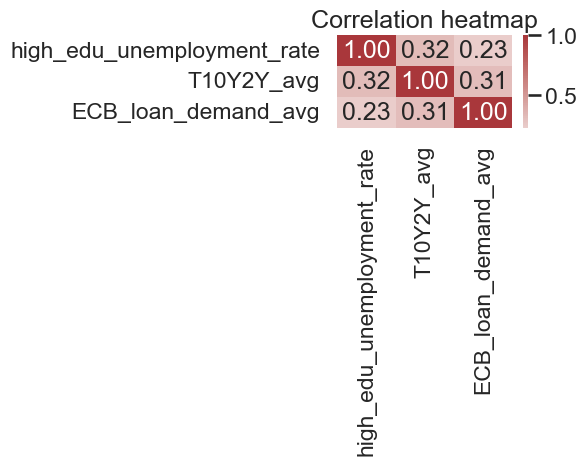

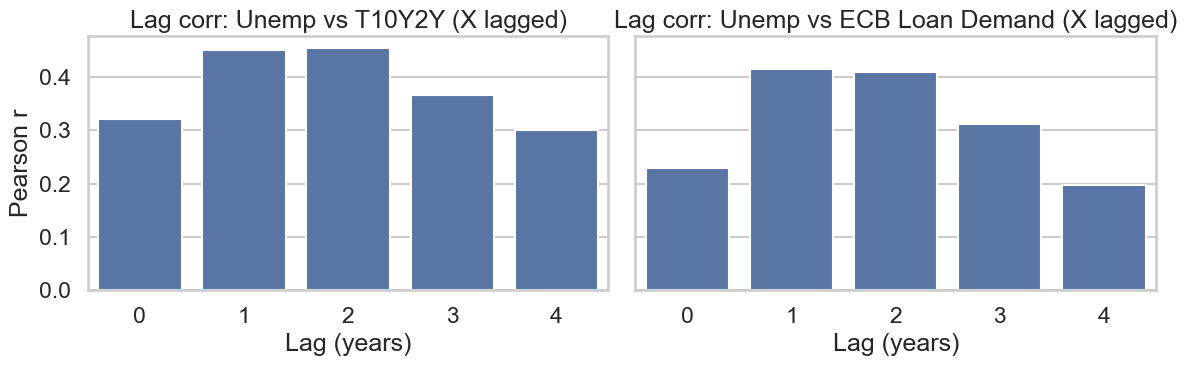

In [43]:
## Use this cell for your code
import numpy as np
sns.set_theme(style="whitegrid", context="talk")


# Overlap
cols = ["year","high_edu_unemployment_rate","T10Y2Y_avg","ECB_loan_demand_avg"]
df = merged.loc[:, [c for c in cols if c in merged.columns]].dropna().sort_values("year")

# --- Summary + correlations ---
print("Years:", df["year"].min(), "→", df["year"].max())
print("\nSummary:\n", df.drop(columns=["year"]).describe().T.round(3))
corr = df.drop(columns=["year"]).corr().round(3)
print("\nCorrelations:\n", corr)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="vlag", center=0, fmt=".2f")
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()



# --- Simple lag correlations---
def lag_corr(df, ycol, xcol, max_lag=4):
    y = df[ycol].to_numpy()
    x = df[xcol].to_numpy()
    out = []
    for L in range(max_lag+1):
        if L == 0:
            r = np.corrcoef(y, x)[0,1]
        elif len(y) > L:
            r = np.corrcoef(y[L:], x[:-L])[0,1]
        else:
            r = np.nan
        out.append({"lag_years": L, "pearson_r": r})
    return pd.DataFrame(out)

lags_curve = lag_corr(df, "high_edu_unemployment_rate", "T10Y2Y_avg", max_lag=4)
lags_loan  = lag_corr(df, "high_edu_unemployment_rate", "ECB_loan_demand_avg", max_lag=4)


fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.barplot(data=lags_curve, x="lag_years", y="pearson_r", ax=ax[0])
ax[0].set_title("Lag corr: Unemp vs T10Y2Y (X lagged)")
ax[0].set_xlabel("Lag (years)"); ax[0].set_ylabel("Pearson r")
sns.barplot(data=lags_loan, x="lag_years", y="pearson_r", ax=ax[1])
ax[1].set_title("Lag corr: Unemp vs ECB Loan Demand (X lagged)")
ax[1].set_xlabel("Lag (years)")
plt.tight_layout(); plt.show()


The overall correlation seems quite weak. But as it is always with macroeconomic indicators they are lagging so when looking at the lag it does show some moderate strength in the correlation.

Create a geographical or other type of plot showcasing the trends in the unemployment of highly educated people across different provinces over time. Compare the provinces based on your plot.

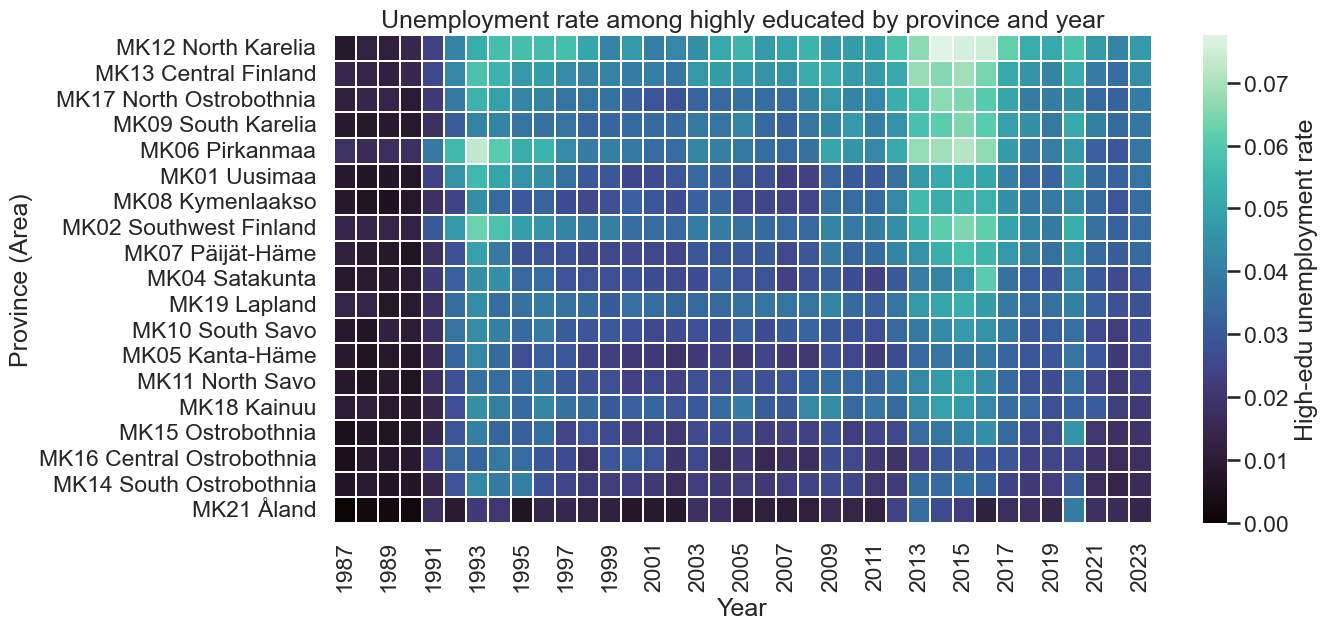

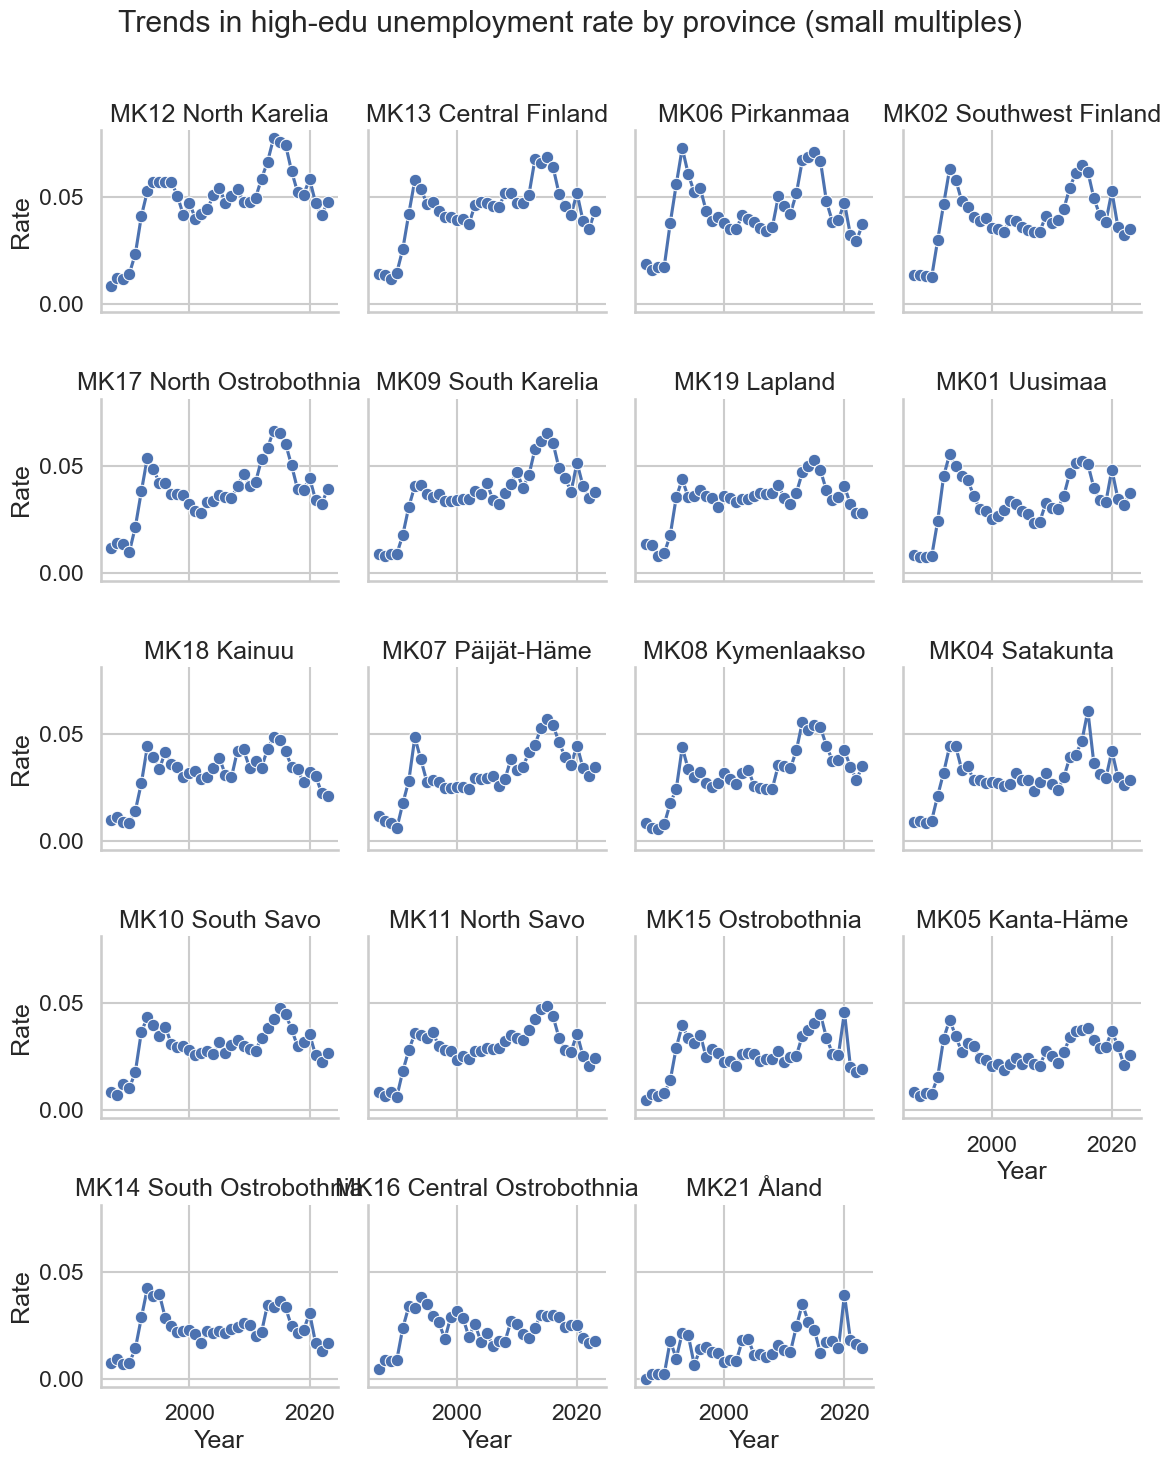

/tmp/ipykernel_69447/2185065105.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.sort_values("year").iloc[[0,-1]][["year","high_edu_unemployment_rate"]]


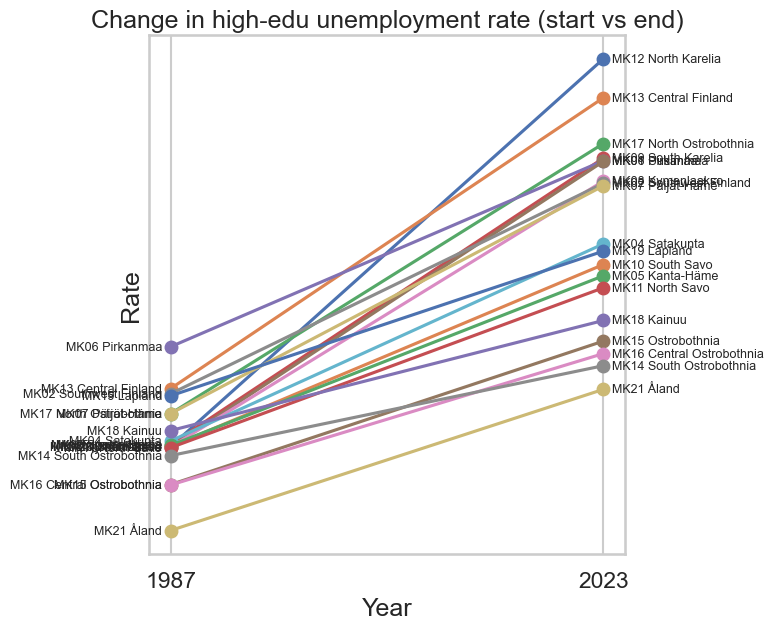


Top provinces by latest available high-edu unemployment rate:
area
MK12 North Karelia         0.048
MK13 Central Finland       0.044
MK17 North Ostrobothnia    0.039
MK09 South Karelia         0.038
MK06 Pirkanmaa             0.037
MK01 Uusimaa               0.037
MK08 Kymenlaakso           0.035
MK02 Southwest Finland     0.035
MK07 Päijät-Häme           0.035
MK04 Satakunta             0.029


In [ ]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

PATH = "/home/haarhaar/koulu/intro/Introduction-to-DataScience/Extra assignments/JyUmCNsMXCGJ3VX2WInilGfPB24AZH.csv"
HIGH = "7-8 Master's or equivalent level or doctoral or equivalent level"

df = (pd.read_csv(PATH, encoding="latin1")
        .rename(columns={
            "Year":"year","Area":"area","Main type of activity":"main_activity",
            "Level of education":"edu_level","Population 31 Dec":"population"
        }))
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["area"] = df["area"].astype(str).str.strip()
df["main_activity"] = df["main_activity"].astype(str).str.strip()
df["edu_level"] = df["edu_level"].astype(str).str.strip()
df["population"] = pd.to_numeric(df["population"], errors="coerce")

df["area"] = (df["area"]
              .str.replace(r"Kanta-H.?me", "Kanta-Häme", regex=True)
              .str.replace(r"P.?ij.?t-H.?me", "Päijät-Häme", regex=True))

def pick(q, name):
    out = (df.query(q)[["year","area","population"]]
             .groupby(["year","area"], as_index=False)
             .sum(min_count=1)
             .rename(columns={"population": name}))
    return out

unemp_high = pick("main_activity == 'Unemployed' and edu_level == @HIGH", "unemployed_high_edu")
total_high = pick("main_activity == 'Total' and edu_level == @HIGH", "total_high_edu_pop")

eda = (unemp_high.merge(total_high, on=["year","area"], how="outer"))
eda["high_edu_unemployment_rate"] = eda["unemployed_high_edu"] / eda["total_high_edu_pop"]
eda = eda.dropna(subset=["year","area"]).sort_values(["area","year"])

# ---- (Area x Year) ----
heat = (eda.pivot_table(index="area", columns="year", values="high_edu_unemployment_rate", aggfunc="mean"))


latest_rate = (eda.dropna(subset=["high_edu_unemployment_rate"])
                 .sort_values(["area","year"])
                 .groupby("area").tail(1)
                 .set_index("area")["high_edu_unemployment_rate"])
order_areas = latest_rate.sort_values(ascending=False).index.tolist()
heat = heat.reindex(order_areas)

plt.figure(figsize=(14, max(6, 0.35*len(heat))))
sns.heatmap(heat, cmap="mako", cbar_kws={"label":"High-edu unemployment rate"}, linewidths=0.3, linecolor="white")
plt.title("Unemployment rate among highly educated by province and year")
plt.xlabel("Year"); plt.ylabel("Province (Area)")
plt.tight_layout()
plt.show()

# ---- Small-multiples ----

counts = eda.groupby("area")["year"].nunique()
keep_areas = counts[counts >= 6].index.tolist()
plot_df = (eda[eda["area"].isin(keep_areas)]
           .dropna(subset=["high_edu_unemployment_rate"]))

# Sort areas by average rate to highlight high vs low unemployment provinces
area_order = (plot_df.groupby("area")["high_edu_unemployment_rate"]
              .mean().sort_values(ascending=False).index.tolist())

g = sns.FacetGrid(plot_df, col="area", col_wrap=4, col_order=area_order,
                  height=3, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="high_edu_unemployment_rate", marker="o")
g.set_axis_labels("Year", "Rate")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Trends in high-edu unemployment rate by province (small multiples)")
plt.show()

# provinces ranked
endpoints = (plot_df.groupby(["area"])
             .apply(lambda d: d.sort_values("year").iloc[[0,-1]][["year","high_edu_unemployment_rate"]]
                   .assign(pos=lambda x: ["start","end"]))
             .reset_index(level=0).reset_index(drop=True))

# Keep only areas present at both endpoints
counts2 = endpoints.groupby("area")["pos"].nunique()
areas_both = counts2[counts2==2].index
endpoints = endpoints[endpoints["area"].isin(areas_both)]

fig, ax = plt.subplots(figsize=(8, max(6, 0.35*len(areas_both))))
start = endpoints[endpoints["pos"]=="start"].set_index("area")
end   = endpoints[endpoints["pos"]=="end"].set_index("area")
rank_df = (pd.DataFrame({
    "area": areas_both,
    "start_year": start["year"],
    "start_rate": start["high_edu_unemployment_rate"],
    "end_year": end["year"],
    "end_rate": end["high_edu_unemployment_rate"],
})
.set_index("area")
.sort_values("end_rate", ascending=False))

# Plot lines area by area
ypos = np.arange(len(rank_df))
for i, (area, row) in enumerate(rank_df.iterrows()):
    ax.plot([0,1], [row["start_rate"], row["end_rate"]], marker="o")
ax.set_xticks([0,1], [f"{int(rank_df['start_year'].iloc[0])}", f"{int(rank_df['end_year'].iloc[0])}"])
ax.set_yticks([])  
ax.set_title("Change in high-edu unemployment rate (start vs end)")
ax.set_xlabel("Year"); ax.set_ylabel("Rate")

# Annotate with labels
for i, (area, row) in enumerate(rank_df.iterrows()):
    ax.text(-0.02, row["start_rate"], f"{area}", va="center", ha="right", fontsize=9)
    ax.text(1.02, row["end_rate"], f"{area}", va="center", ha="left", fontsize=9)

plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


Reflect briefly on your findings. For example, which features seemed interesting with respect to changes in unemployment among the highly educated population? How do different provinces compare? What should be done to ensure that the number of unemployed highly educated people can be compared fairly across years and provinces? 

**Hint**: should we look at the raw numbers or maybe consider them relative to something else?

## Exercise 2: AI Act

In this exercise, we ask you to think about the different AI services you come accross in your daily life and consider them in terms of the AI Act's risk pyramid.

1. Brainstorm & List: For 48 hours, keep a log of every application, software, or service you interact with that you suspect uses AI. Think about social media feeds, recommendation engines (Netflix, Spotify, Amazon), grammar checkers, spam filters, navigation apps, and virtual assistants. We'd expect that most of you will be able to identify at least 10 examples.

2. Select & Analyze: Choose three distinct AI systems from your list. For each one, research and describe its primary function and how AI is used to achieve it.

3. Classify the Risk: Using the AI Act's risk pyramid as a guide, classify each of your three chosen AI systems into one of the four categories:
	- Unacceptable Risk: Is the AI system doing something that is explicitly banned (e.g., social scoring, real-time remote biometric identification in public spaces by law enforcement)?
	- High-Risk: Could the system have a significant impact on your safety, fundamental rights, or access to essential services? (e.g., AI used in educational scoring, recruitment, or credit scoring). Justify why it falls into a specific high-risk category listed in Annex III of the Act.
	- Limited or Minimal Risk: Does the system interact with you in a way that should require transparency? (e.g., chatbots, deepfakes, generative AI).

4. Justify Your Reasoning: For each classification, write a short paragraph explaining your decision, referencing specific criteria from the AI Act.